In [2]:
from qiskit import IBMQ
IBMQ.save_account('4a0a818b1d1a7766e8274535f2e9a7a4a625d381fec20e64c9fc1daaaed0b4b205a81931a0ba343e844dc85c8a32cf4a99dfc298aea947d1492c77bdcd18311f')

configrc.store_credentials:WARNING:2023-01-24 12:58:40,985: Credentials already present. Set overwrite=True to overwrite.


In [3]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
import numpy as np


In [18]:
def oracle(qc, qreg_q):
    qc.cz(qreg_q[0], qreg_q[3])
    qc.cz(qreg_q[1], qreg_q[4])
    qc.cz(qreg_q[2], qreg_q[5])

    return qc


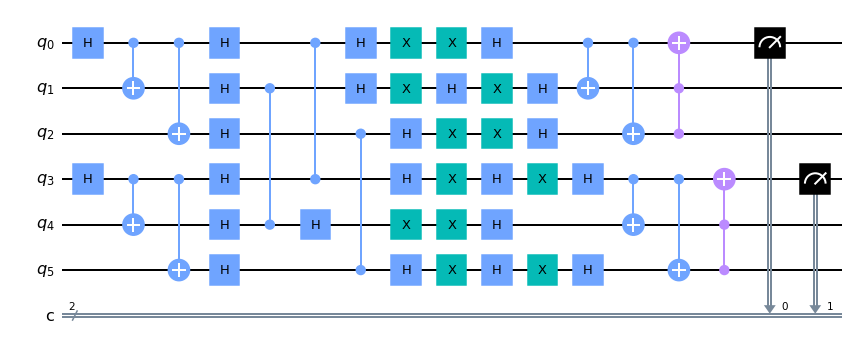

In [19]:
qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
corr_circuit = QuantumCircuit(qreg_q, creg_c)

# initialize
corr_circuit.h(qreg_q[0])
corr_circuit.h(qreg_q[3])

# Phase flip encode
corr_circuit.cx(qreg_q[0], qreg_q[1])
corr_circuit.cx(qreg_q[0], qreg_q[2])

corr_circuit.cx(qreg_q[3], qreg_q[4])
corr_circuit.cx(qreg_q[3], qreg_q[5])

for i in range(6):
    corr_circuit.h(qreg_q[i])

# Oracle
corr_circuit = oracle(corr_circuit, qreg_q)

# Diffuser
for i in np.arange(0, 5, 2):
    corr_circuit.h(qreg_q[i])
    corr_circuit.x(qreg_q[i])
    corr_circuit.x(qreg_q[i])
    corr_circuit.h(qreg_q[i])

for i in np.arange(1, 6, 2):
    corr_circuit.h(qreg_q[i])
    corr_circuit.x(qreg_q[i])
    corr_circuit.h(qreg_q[i])
    corr_circuit.x(qreg_q[i])
    corr_circuit.h(qreg_q[i])

# Phase flip decode
corr_circuit.cx(qreg_q[0], qreg_q[1])
corr_circuit.cx(qreg_q[0], qreg_q[2])

corr_circuit.cx(qreg_q[3], qreg_q[4])
corr_circuit.cx(qreg_q[3], qreg_q[5])

corr_circuit.ccx(qreg_q[2], qreg_q[1], qreg_q[0])
corr_circuit.ccx(qreg_q[5], qreg_q[4], qreg_q[3])

corr_circuit.measure(qreg_q[0], creg_c[0])
corr_circuit.measure(qreg_q[3], creg_c[1])

corr_circuit.draw(output='mpl')

In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    return qc

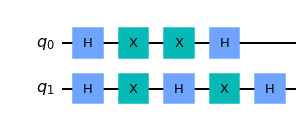

In [10]:
qc = diffuser(2)
qc.draw(output='mpl')

In [20]:
def his_sim(circuit):
    aer_sim = Aer.get_backend('aer_simulator')
    qobj = assemble(circuit)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts()
    return counts

In [21]:
counts = his_sim(corr_circuit)
print(counts)

{'10': 245, '00': 262, '11': 260, '01': 257}
